# MOSCOW REAL ESTATE PRICES
**_Doing to houses & apartments what we did to cars_**
### Data Science 410 BB
#### University of Washington Professional & Continuing Education
#### FINAL PROJECT
#### Leo Salemann, 3/10/18

# INTRODUCTION

Our dataset comes from a [Kaggle competition to predict real Moscow esate prices](https://www.kaggle.com/c/sberbank-russian-housing-market). I first encountered this data in a [team project](https://www.slideshare.net/LeoSalemann/predicting-moscow-real-estate-prices-with-azure-machine-learning) for [UW PCE Big Data Technologies - Introduciton to Data Engineering](https://www.pce.uw.edu/courses/introduction-to-data-engineering). We used [Microsoft Azure Machine Learning Studio](https://gallery.cortanaintelligence.com/Experiment/D-Hawks-Big-Data-Project-Leo-RevS) to look at multiple approaches to feature engineering, and try multiple machine learning models simultaneosly. For this project, we'll extract realestate data from Azure ML Studio, after cleaning but before any Azure ML modeling.  We'll then do our own feature analysis in Jupyter Notebook with R.

The [original kaggle datasets](https://www.kaggle.com/c/sberbank-russian-housing-market/data) consisted of two tables: Real Estate Transactions and Macro Economics. The Real Estate Transactions table includes price, timestamp, year built, property descriptors such as  square footage, number of floors, condition, etc. and neighborhood descriptors such as nearby transportation, industry, population demographics. 

Azure ML Studio Summary
1. Start with the original 30,471 rows and 292 columns
1. Select 64 columns to work with.
1. Set a bunch of numeric data to floating point, integer, category
1. Clean missing data
1. Apply SQL Transofmation (see below)
1. Normalize non-categorical rows


Cleaning missing data

|Field                         |Set To   |Rows Affected|
|------------------------------|---------|-------------|
|build_year                    |1979     |13,605       |
|life_sq (living space, m$^2$) |30       | 6,383       |
|floor (level above ground)    |7        |   167       |
|num_room                      |2        | 9,572       |
|kitch_sq (kitchen space m$^2$)|6        | 9,572       |
|material                      |mode\*   | 9,672       |
|state                         |MICE\*\* |0            |
|full_sq (total m$^2$)         |mode\*   |0            |
|max_floor (highest, 0=ground) |0        | 9,571       |
|metro_min_walk                |median   |    25       |
|railroad_station_walk_km      |median   |    25       |
|railroad_station_walk_min     |median   |    25       |
|metro_km_walk                 |median   |    25       |




\* replace nulls with the mode of the non-null data

\*\* [Multivariate Imputation using Chaned Equations](https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/clean-missing-data)

## SQL Filtering

# DATA EXPLORATION

## Load the data, have a quick look

In [24]:
# real_estate = read.csv("D-Hawks Big Data Project Leo _RevS_cleaned_sql_normed.csv")
real_estate = read.csv("D-Hawks Big Data Project Leo _RevS_cleaned_sql.csv")
dim(real_estate)
head(real_estate)
str(real_estate)

[1] 15693    64

timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,⋯,prom_part_2000,office_count_2000,office_sqm_2000,prom_part_3000,office_count_3000,office_sqm_3000,prom_part_5000,office_count_5000,office_sqm_5000,price_doc
4/27/2013 12:00:00 AM,73,36,17,17,1,1979,2,11,3,⋯,8.44,0,0,8.28,0,0,6.22,2,138650,10100000
5/25/2013 12:00:00 AM,53,30,10,16,1,1980,2,8,3,⋯,17.64,10,179554,16.69,14,529054,18.47,25,766701,9000000
5/27/2013 12:00:00 AM,41,37,13,17,1,1979,1,1,1,⋯,1.45,0,0,2.01,0,0,4.45,0,0,4457400
5/27/2013 12:00:00 AM,77,41,2,17,6,2014,3,12,1,⋯,1.64,0,0,1.98,0,0,4.75,0,0,7011550
5/27/2013 12:00:00 AM,45,27,6,9,1,1970,2,6,3,⋯,0.74,0,0,1.99,1,15000,8.05,3,81947,7100000
5/28/2013 12:00:00 AM,38,20,15,16,1,1982,1,8,3,⋯,21.51,4,31280,18.78,15,136990,11.12,83,3903973,6450000


'data.frame':	15693 obs. of  64 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 335 382 387 387 387 390 390 395 416 464 ...
 $ full_sq                          : int  73 53 41 77 45 38 63 74 51 77 ...
 $ life_sq                          : int  36 30 37 41 27 20 30 46 30 50 ...
 $ floor                            : int  17 10 13 2 6 15 17 12 7 3 ...
 $ max_floor                        : int  17 16 17 17 9 16 17 24 17 5 ...
 $ material                         : int  1 1 1 6 1 1 4 1 1 2 ...
 $ build_year                       : int  1979 1980 1979 2014 1970 1982 2013 2004 2003 1957 ...
 $ num_room                         : int  2 2 1 3 2 1 2 3 2 3 ...
 $ kitch_sq                         : int  11 8 1 12 6 8 1 9 9 8 ...
 $ state                            : int  3 3 1 1 3 3 1 3 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 2 1 1 2 1 1 1 ...
 $ sub_area                         : Factor 

## Data Cleanups
 - **Drop NA Values**
 - **Parse the Date**
 - **Create a price per square meter**

In [25]:
real_estate = na.omit(real_estate)
dim(real_estate)
real_estate$date = as.Date(real_estate$timestamp,format='%m/%d/%Y')
real_estate$year_sold  = 
    as.numeric(format(as.Date(real_estate$timestamp,format='%m/%d/%Y'), '%Y'))
real_estate$month_sold = 
    as.numeric(format(as.Date(real_estate$timestamp,format='%m/%d/%Y'), '%m'))
real_estate$day_sold   = 
    as.numeric(format(as.Date(real_estate$timestamp,format='%m/%d/%Y'), '%d'))
real_estate$price_sqm = real_estate$price_doc/real_estate$full_sq
head(real_estate, 3)
str(real_estate)

[1] 9233   64

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,⋯,office_sqm_3000,prom_part_5000,office_count_5000,office_sqm_5000,price_doc,date,year_sold,month_sold,day_sold,price_sqm
5,5/27/2013 12:00:00 AM,45,27,6,9,1,1970,2,6,3,⋯,15000,8.05,3,81947,7100000,2013-05-27,2013,5,27,157777.78
6,5/28/2013 12:00:00 AM,38,20,15,16,1,1982,1,8,3,⋯,136990,11.12,83,3903973,6450000,2013-05-28,2013,5,28,169736.84
7,5/28/2013 12:00:00 AM,63,30,17,17,4,2013,2,1,1,⋯,0,6.54,1,26950,5903808,2013-05-28,2013,5,28,93711.24


'data.frame':	9233 obs. of  69 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 387 390 390 395 416 464 474 474 474 410 ...
 $ full_sq                          : int  45 38 63 74 51 77 52 56 31 43 ...
 $ life_sq                          : int  27 20 30 46 30 50 33 29 21 27 ...
 $ floor                            : int  6 15 17 12 7 3 13 5 5 1 ...
 $ max_floor                        : int  9 16 17 24 17 5 25 16 9 5 ...
 $ material                         : int  1 1 4 1 1 2 2 5 5 2 ...
 $ build_year                       : int  1970 1982 2013 2004 2003 1957 2004 1987 1962 1960 ...
 $ num_room                         : int  2 1 2 3 2 3 2 2 1 2 ...
 $ kitch_sq                         : int  6 8 1 9 9 8 7 10 5 5 ...
 $ state                            : int  3 3 1 3 3 2 3 2 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 1 1 1 1 1 1 1 ...
 $ sub_area                         : Factor w/ 126

## Density Plot for Price

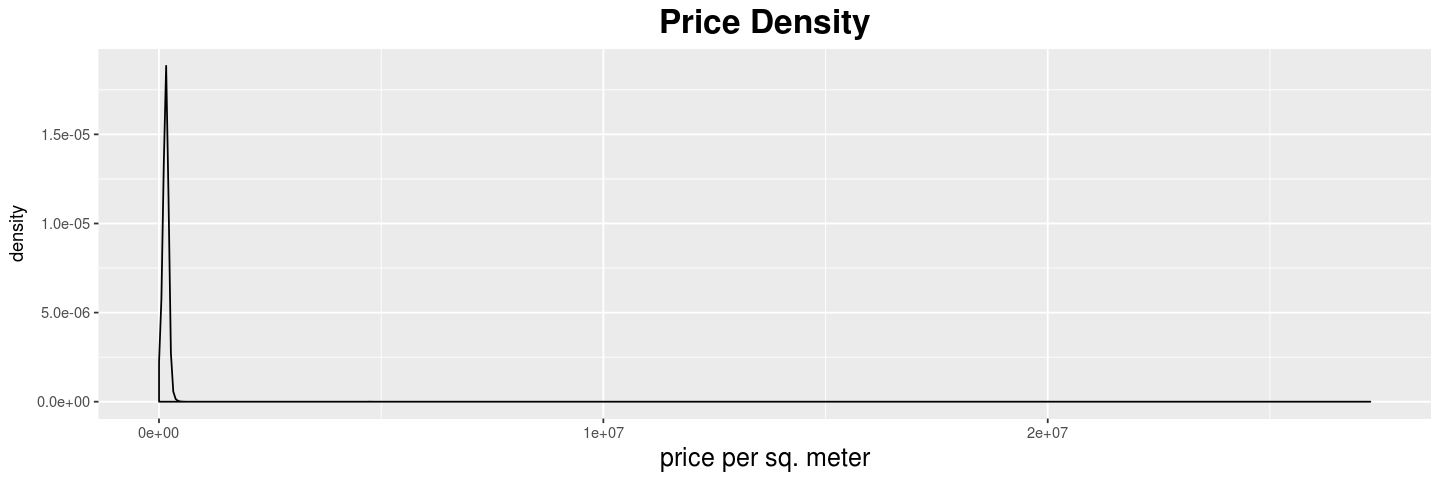

In [26]:
options(repr.plot.width=12, repr.plot.height=4)
ggplot(real_estate, aes(price_sqm)) + 
      geom_density() + 
      xlab("price per sq. meter") + 
      ggtitle("Price Density") + 
      theme(plot.title = element_text(hjust = 0.5, size=20, face="bold"),
           axis.title.x = element_text(size=15))

## Take the log, Plot again

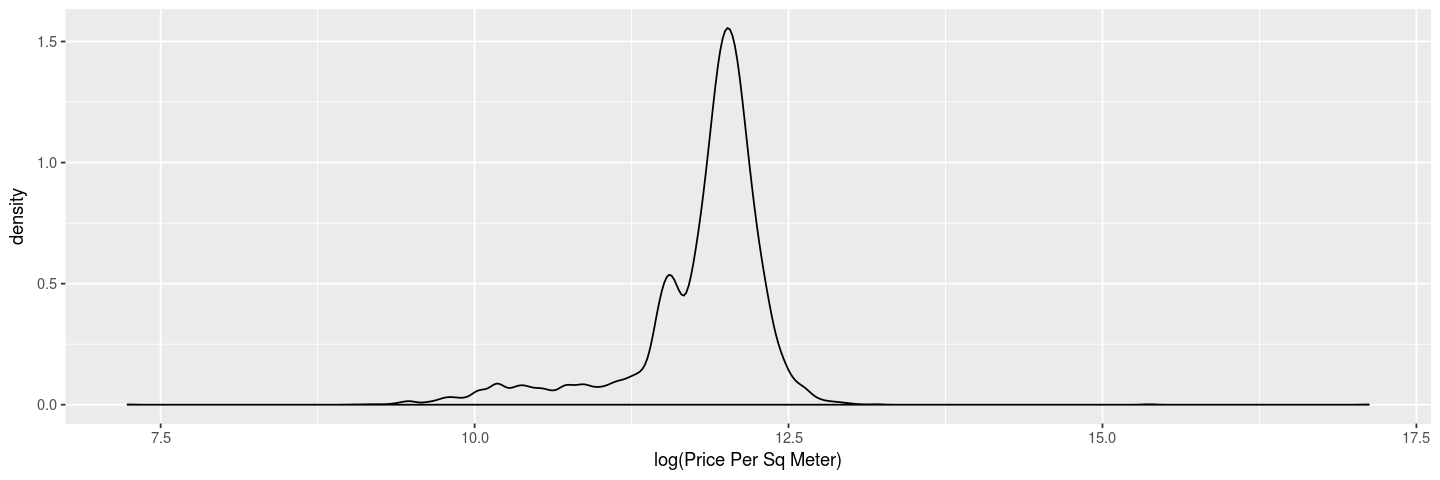

In [27]:
options(repr.plot.width=12, repr.plot.height=4)
real_estate$log.price_sqm = log(real_estate$price_sqm)
# head(real_estate)
ggplot(real_estate, aes(log.price_sqm)) + geom_density() + 
xlab('log(Price Per Sq Meter)')

## Trim the tails, Plot again

Warning message:
“Removed 52 rows containing non-finite values (stat_density).”

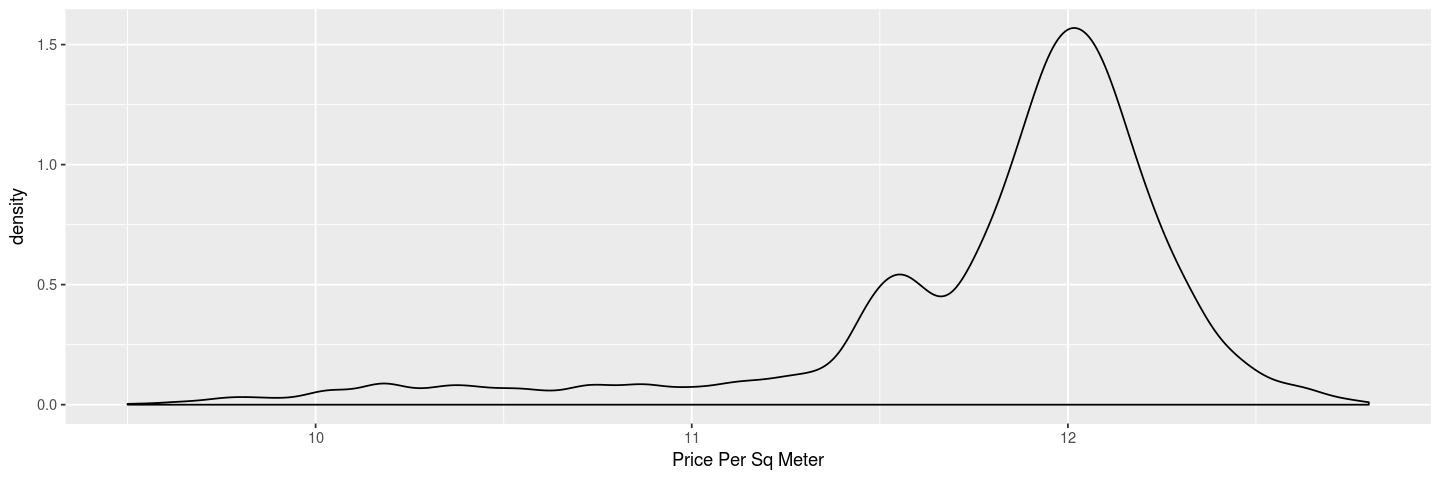

In [28]:
x_min = 9.5 # was 9.5
x_max = 12.8

ggplot(real_estate, aes(log.price_sqm)) + 
geom_density() + xlab('Price Per Sq Meter') + 
xlim(c(x_min, x_max)) 

## Use what we learned to trim the dataframe

In [29]:
real_estate.trimmed = real_estate[real_estate$log.price_sqm <= x_max,]
real_estate.trimmed = real_estate.trimmed[real_estate.trimmed$log.price_sqm >= x_min,]
dim(real_estate)
dim(real_estate.trimmed)
real_estate = real_estate.trimmed

[1] 9233   70

[1] 9181   70

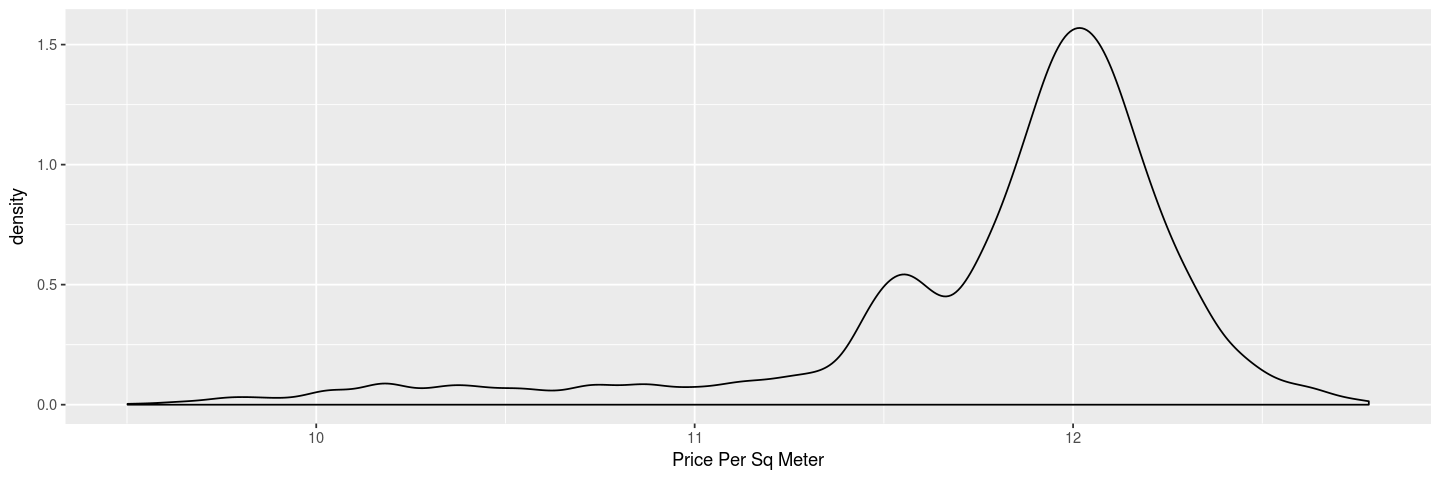

In [23]:
ggplot(real_estate, aes(log.price_sqm)) + 
geom_density() + xlab('Price Per Sq Meter')

## A Scatterng of Scatterplots: The search for meaning

Time to walk thru the dataset looking for features that have some kind of relationship with price per square foot. As we go along, we'll keep track of features which have non-zero trendlines, or that show promise as a categorical feature for splitting data.  Basically, we're looking for regression lines (solid green) with non-zero slopes and narrow confidence intervals (dashed red).  For categoricals, we're looking for "spiky" density plots.

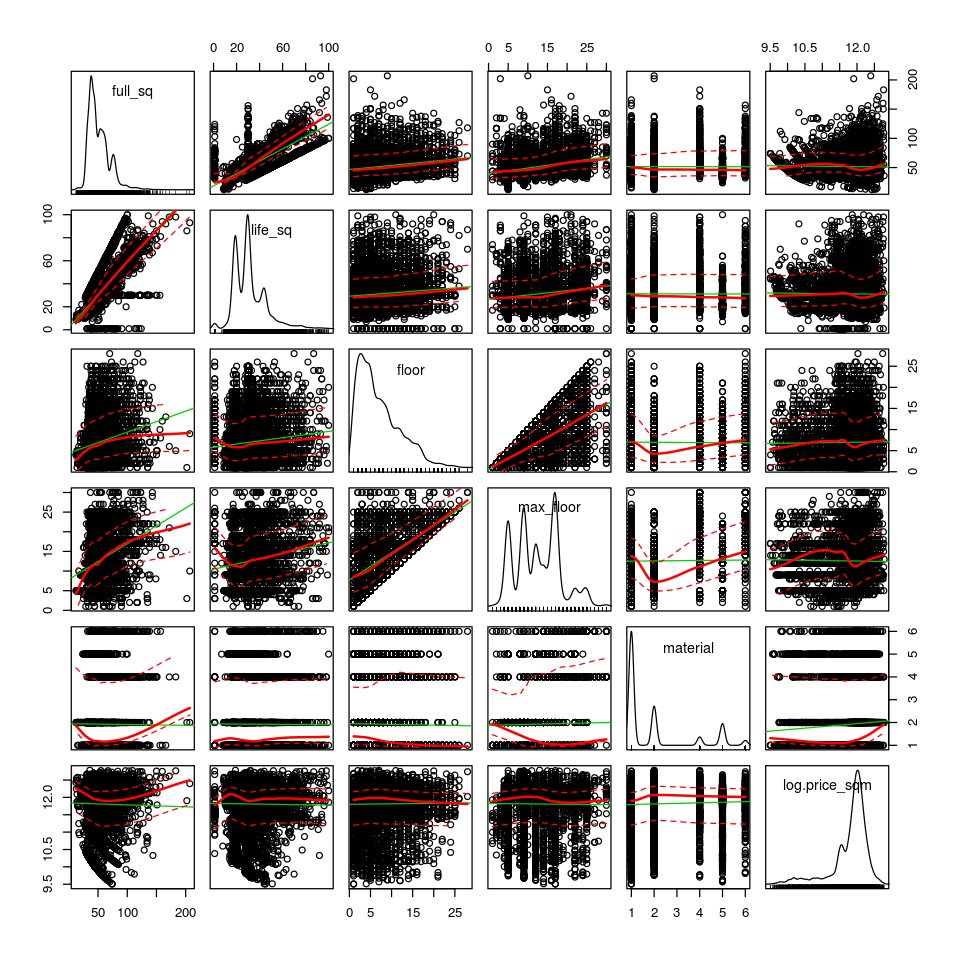

In [33]:
options(repr.plot.width=8, repr.plot.height=8)
require(car)

scatterplotMatrix(~ 
                  full_sq +
                  life_sq +
                  floor +
                  max_floor +
                  material +
                  log.price_sqm,
                  data = real_estate)

The rightmost column and and bottom row show relationships to log of the price per square foot (our target variable). The regression lines are all pretty flat, but _material_ looks like a potential categorical variable. 

So far ...
- Potential numerics: none
- Potential categoricals: 1
  - material
  
Moving on ...

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
require(car)

scatterplotMatrix(~ 
                  build_year +
                  num_room +
                  kitch_sq +
                  hospital_beds_raion +
                  healthcare_centers_raion +
                  log.price_sqm,
                  data = real_estate)

The rightmost column and and bottom row show relationships to log of the price per square foot (our target variable). The regression lines are all pretty flat, but _material_ looks like a potential categorical variable. 

So far ...
- Potential numerics: none
- Potential categoricals: 1
  - material
  
Moving on ...

In [ ]:
scatterplotMatrix(~ 
                 state +
                  office_raion   +
                  metro_min_avto +
                  metro_km_avto  +
                  metro_min_walk +
                  metro_km_walk +
                  log.price_sqm,
                  data = real_estate)

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
require(car)

scatterplotMatrix(~ 
                    railroad_station_walk_km          +
                    railroad_station_walk_min         +
                    railroad_station_avto_km          +
                    railroad_station_avto_min         +
                   railroad_km                      +
                  log.price_sqm,
                  data = real_estate)

In [ ]:
scatterplotMatrix(~ 
                public_transport_station_km       +
                public_transport_station_min_walk +
                big_road1_km                     +
                big_road2_km                     +
                zd_vokzaly_avto_km               +
                bus_terminal_avto_km             +
                  log.price_sqm,
                  data = real_estate)

In [ ]:
scatterplotMatrix(~ 
                oil_chemistry_km                 +
                hospice_morgue_km                +
                detention_facility_km            +
                public_healthcare_km             +
                  log.price_sqm,
                  data = real_estate)

In [ ]:
scatterplotMatrix(~ 
                office_km                        +
                office_count_500                 +
                office_count_1000                +
                office_count_1500                +
                office_count_2000                +
                office_count_3000                +
                office_count_5000                +
                  log.price_sqm,
                  data = real_estate)

In [ ]:
scatterplotMatrix(~ 
                  prom_part_500                    +
                  prom_part_1000                   +
                  prom_part_1500                   +
                  prom_part_2000                   +
                  prom_part_3000                   +
                  prom_part_5000                   +

                  log.price_sqm,
                  data = real_estate)

In [ ]:
scatterplotMatrix(~ 
                  kitch_sq +
                  hospital_beds_raion +
                  build_year +
                  metro_km_walk +           
                  log.price_sqm,
                  data = real_estate)

In [ ]:
scatterplotMatrix(~ 
                  zd_vokzaly_avto_km +
                  big_road1_km +
                  public_healthcare_km +
                  office_km +
                  prom_part_1500 +
                  log.price_sqm,
                  data = real_estate)

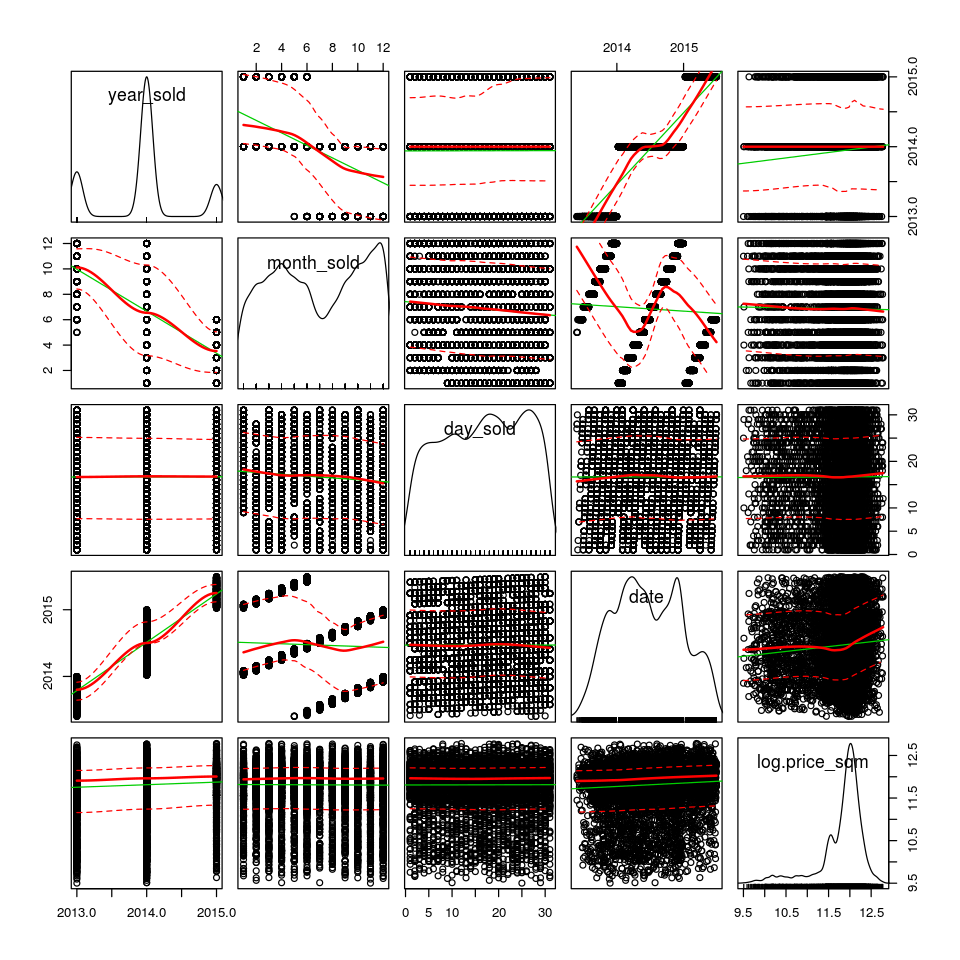

In [32]:
scatterplotMatrix(~ 
                  year_sold +
                  month_sold +
                  day_sold +
                  date +
                  log.price_sqm,
                  data = real_estate)

In [ ]:
Potential Categories
- Material
- healthcare_centers_raion
- state
Potential Parameters (ordered by influence)
- zd_vokzaly_avto_km
- office_km
- public_healthcare_km
- prom_part_1500

- kitch_sq
- hospital_beds_raion
- build_year
- metro_km_walk
- big_road1_km